<a href="https://colab.research.google.com/github/edocampione/Week1-Meeting/blob/main/PantryPalEnv_and_initial_qlearning_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import gym
from gym import spaces

class PantryPalEnv(gym.Env):
    """
    A simplified Gym environment for PantryPal's path planning.
    """
    metadata = {'render.modes': ['console']}

    def __init__(self):
        super(PantryPalEnv, self).__init__()

        # Define the size of the grid (5x5 for simplicity)
        self.grid_size = 5
        self.obstacle = -1  # Represents an obstacle
        self.free_space = 0  # Represents a free space
        self.perishable_item = 1  # Represents a perishable item
        self.storage_location = 2  # Represents the storage location

        # Define action and observation space
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = spaces.Box(low=0, high=self.grid_size, shape=(2,), dtype=int)

        # Initial position of the robot and the target storage
        self.robot_position = [0, 0]
        self.storage_position = [self.grid_size - 1, self.grid_size - 1]

        # Initialize the grid
        self.grid = np.zeros((self.grid_size, self.grid_size))
        self.grid[self.storage_position[0], self.storage_position[1]] = self.storage_location

        # Place an obstacle and a perishable item in the grid
        self.grid[1, 1] = self.obstacle
        self.grid[2, 2] = self.perishable_item

    def step(self, action):
        """
        Execute one time step within the environment.
        """
        if action == 0 and self.robot_position[0] > 0:  # up
            self.robot_position[0] -= 1
        elif action == 1 and self.robot_position[0] < self.grid_size - 1:  # down
            self.robot_position[0] += 1
        elif action == 2 and self.robot_position[1] > 0:  # left
            self.robot_position[1] -= 1
        elif action == 3 and self.robot_position[1] < self.grid_size - 1:  # right
            self.robot_position[1] += 1

        reward = -1  # Default reward is -1 for each step

        # Check if the robot has reached the storage or encountered an obstacle
        current_cell = self.grid[self.robot_position[0], self.robot_position[1]]
        if current_cell == self.storage_location:
            reward = 10  # Reached the storage
        elif current_cell == self.obstacle:
            reward = -10  # Hit an obstacle

        done = reward == 10  # Episode is done if the storage is reached

        info = {}

        return self.robot_position, reward, done, info

    def reset(self):
        """
        Reset the state of the environment to an initial state.
        """
        self.robot_position = [0, 0]  # Reset robot position
        return self.robot_position  # Return initial observation

    def render(self, mode='console'):
        """
        Render the environment to the console.
        """
        if mode != 'console':
            raise NotImplementedError("Only 'console' mode is supported.")

        grid_copy = np.copy(self.grid)
        grid_copy[self.robot_position[0], self.robot_position[1]] = 9  # Temporary marker for the robot

        for row in grid_copy:
            print(" ".join(str(int(cell)) for cell in row))



9 0 0 0 0
0 -1 0 0 0
0 0 1 0 0
0 0 0 0 0
0 0 0 0 2


In [ ]:

# Create the environment and test rendering
env = PantryPalEnv()
env.reset()
env.render()

9 0 0 0 0
0 -1 0 0 0
0 0 1 0 0
0 0 0 0 0
0 0 0 0 2


In [ ]:
env.observation_space.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2,)

In [ ]:
import numpy as np
import random

# Assuming PantryPalEnv is your environment class
env = PantryPalEnv()

# Parameters
learning_rate = 0.1
discount_factor = 0.99
exploration_rate = 1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.01
exploration_decay_rate = 0.001
total_episodes = 1000
grid_size = 5  # Assuming a grid size of 5x5 for this environment

# Adjusted Q-table initialization to match the linearized state space and action space
q_table = np.zeros((grid_size * grid_size, env.action_space.n))

def get_linear_state_index(state):
    """Convert a 2D state into a 1D index for the Q-table."""
    return state[0] * grid_size + state[1]
total_rewards = []

for episode in range(total_episodes):
    state = env.reset()
    linear_state_index = get_linear_state_index(state)
    done = False
    rewards_current_episode = 0

    while not done:
        # Exploration-exploitation trade-off
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[linear_state_index,:])
        else:
            action = env.action_space.sample()

        new_state, reward, done, info = env.step(action)
        new_linear_state_index = get_linear_state_index(new_state)

        # Update Q-table
        q_table[linear_state_index, action] = q_table[linear_state_index, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_factor * np.max(q_table[new_linear_state_index, :]))

        state = new_state
        linear_state_index = new_linear_state_index  # Update linear index for the new state
        rewards_current_episode += reward
    total_rewards.append(rewards_current_episode)
    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


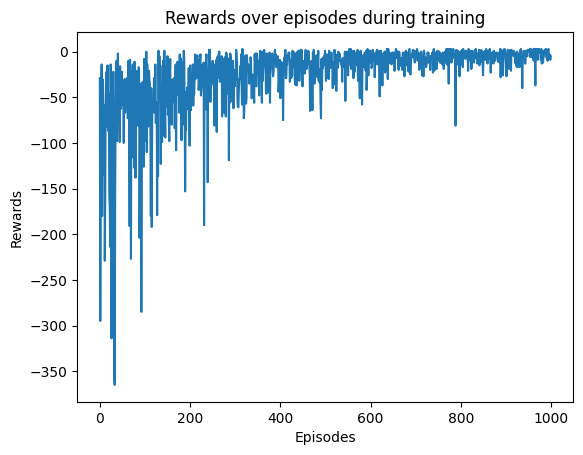

In [ ]:
import matplotlib.pyplot as plt

plt.plot(total_rewards)
plt.title("Rewards over episodes during training")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()